In [5]:
from random import *
import matplotlib.pyplot as plt
import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [6]:
def plot_individuo(individuo, title):
    x_values = [pos[0] for pos in individuo]
    y_values = [pos[1] for pos in individuo]

    fig, ax = plt.subplots()

    plt.plot(x_values, y_values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('X')
    plt.yticks(range(0, 49, 1))
    plt.ylabel('Y')
    plt.grid(True, linestyle='--', color='gray', linewidth=0.09)
    plt.show()

In [48]:


class AlgoritmoGenetico:
    def __init__(self, quantidade_de_formigas = 10, quantidade_de_ciclos = 100):
        self.posicao_queijo = (49, randint(0, 49))
        self.posicao_inicial_individuos = (0, randint(0, 49))
        self.feromonio = {}
        self.matrix_cromossomos = []

        # Inicializar feromônio
        for indexX in range(0, 49):
            self.feromonio[str(indexX)] = [1 for _ in range(49)]
        self.executar(quantidade_de_ciclos,quantidade_de_formigas)

    def calcular_distancia_entre_dois_pontos(self, p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        distancia = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distancia

    def gerar_individuo(self):
        individuo = []
        individuo.append(self.posicao_inicial_individuos)
        individuo.append((individuo[- 1][0] + 1, individuo[- 1][1]))
        while individuo[-1][0] != 49:
          possiveis_caminhos = []
          index_selecionado_para_o_proximo_movimento = 0
          lista_de_chance_por_caminho = []
          divisor = 0

          for caminho_futuro in range(0, 49):
            possiveis_caminhos.append([self.calcular_distancia_entre_dois_pontos(individuo[- 1], (len(individuo), caminho_futuro)), caminho_futuro])

          for i in range(0, len(possiveis_caminhos)):
            divisor = divisor + (self.feromonio[str(individuo[-1][0])][i] * (1 / possiveis_caminhos[i][0]))
          for i in possiveis_caminhos:
            lista_de_chance_por_caminho.append([(self.feromonio[str(individuo[-1][0])][i[1]] * (1 / i[0]) )/ divisor , i])


          maior_valor = max(lista_de_chance_por_caminho, key=lambda x: x[0])
          numero_gerado = uniform(0, (maior_valor[0] * 1.5))

          lista_de_chance_por_caminho = sorted(lista_de_chance_por_caminho, key=lambda x: x[0])


          for i in range(0, len(lista_de_chance_por_caminho)):
            if i  == 0 and numero_gerado < lista_de_chance_por_caminho[i][0]:
              index_selecionado_para_o_proximo_movimento = lista_de_chance_por_caminho[i][1][1]
              break

            if i == 48:
              index_selecionado_para_o_proximo_movimento = lista_de_chance_por_caminho[i][1][1]
              break

            if numero_gerado > lista_de_chance_por_caminho[i - 1][0] and numero_gerado < lista_de_chance_por_caminho[i + 1][0]:
              index_selecionado_para_o_proximo_movimento = lista_de_chance_por_caminho[i][1][1]
              break

          nova_posicao = (
              individuo[- 1][0] + 1,
              index_selecionado_para_o_proximo_movimento
          )
          if individuo[-1][0] == 48:
            individuo.append(self.posicao_queijo)
            return individuo


          if nova_posicao[0] >= 0 and nova_posicao[0] <= 49 and nova_posicao[1] >= 0 and nova_posicao[1] <= 49:
            individuo.append(nova_posicao)

    def calcular_distancia_total(self, cromossomo):
        distancia_total = 0
        for i in range(len(cromossomo) - 1):
            distancia_entre_dois_pontos = self.calcular_distancia_entre_dois_pontos(cromossomo[i], cromossomo[i + 1])
            distancia_total += distancia_entre_dois_pontos

        return distancia_total

    def ordenar_ranking(self, matrix_cromossomos):
        distancias = [(cromossomo, self.calcular_distancia_total(cromossomo)) for cromossomo in matrix_cromossomos]

        # Ordenar a lista de tuplas com base na distância total
        distancias_ordenadas = sorted(distancias, key=lambda x: x[1])
        plot_individuo(distancias_ordenadas[0][0],'melhor da interação '+str(str(self.calcular_distancia_total(self.matrix_cromossomos[-1]))))

        # Montar o ranking
        ranking = [cromossomo for cromossomo, distancia in distancias_ordenadas]


        return ranking[::-1]

    def cruzar_dois_cromossomos(self, cromossomo1, cromossomo2):
        mascara = [choice([0, 1]) for _ in range(50)]
        filho1 = []
        filho2 = []
        for i in range(0,len(mascara)):
          if mascara[i] == 0:
            filho1.append(cromossomo1[i])
          else:
            filho1.append(cromossomo2[i])

        for i in range(0,len(mascara)):
          if mascara[i] == 0:
            filho2.append(cromossomo2[i])
          else:
            filho2.append(cromossomo1[i])
        return filho1, filho2
    def cruzar_cromossomos_ranking(self, ranking):
        matrix_cromossomos_cruzados = []
        for i in range(0,int(len(ranking)/2), 2):
          filho1, filho2 = self.cruzar_dois_cromossomos(ranking[i],ranking[i+1])
          matrix_cromossomos_cruzados.append(filho1)
          matrix_cromossomos_cruzados.append(filho2)
        return self.gerar_cromossomos_faltantes(matrix_cromossomos_cruzados,int(len(ranking)/2))

    def gerar_cromossomos_faltantes(self, matrix_cromossomos_cruzados_local, quantidade_de_cromossomos_a_serem_gerados):
        for i in range(0, quantidade_de_cromossomos_a_serem_gerados):
          matrix_cromossomos_cruzados_local.append(self.gerar_individuo(self.feromonio))
        return matrix_cromossomos_cruzados_local

    def atualizar_feromonio(self, matrix_cromossomos):
        feromonio_copy = {}
        for indexX in range(0, 49):
          feromonio_copy[str(indexX)] = [0 for _ in range(50)]
        tamanho_do_percurso = self.calcular_distancia_total(matrix_cromossomos[0])
        for cromossomo in matrix_cromossomos:
          for posicao in cromossomo:
            if(posicao[0] < 49):
              feromonio_copy[str(posicao[0])][posicao[1]] += 1/tamanho_do_percurso

        taxa_de_evaporacao = 0.7
        for indexX in range(0,49):
          for indexY in range(0,len(self.feromonio[str(indexX)])):
            self.feromonio[str(indexX)][indexY] = self.feromonio[str(indexX)][indexY] * taxa_de_evaporacao + feromonio_copy[str(indexX)][indexY]

    def gerar_todos_individuos(self, quantidade_de_formigas):
        for i in range(0, quantidade_de_formigas):
            self.matrix_cromossomos.append(self.gerar_individuo())

    def gerar_mapa_feromonio(self):
      lista_feromonio = []
      for i in self.feromonio:
        lista_feromonio.append(self.feromonio[i])
      scaler = MinMaxScaler()
      dados_normalizados = scaler.fit_transform(lista_feromonio)
      dados_normalizados = np.rot90(dados_normalizados)
      plt.imshow(dados_normalizados , cmap = 'magma' , interpolation = 'lanczos' )

      plt.title( "2-D Heat Map" )
      plt.show()

    def executar(self, quantidade_de_ciclos, quantidade_de_formigas):

      for i in range(0, quantidade_de_ciclos):
        self.matrix_cromossomos = []
        self.gerar_todos_individuos(quantidade_de_formigas)
        ranking = self.ordenar_ranking(self.matrix_cromossomos)
        self.atualizar_feromonio(self.matrix_cromossomos)




      self.gerar_mapa_feromonio()






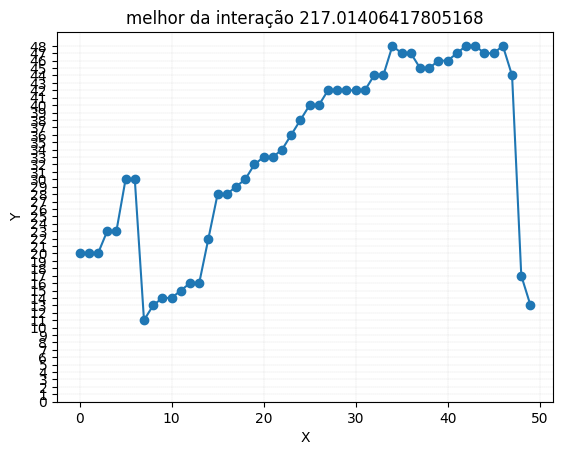

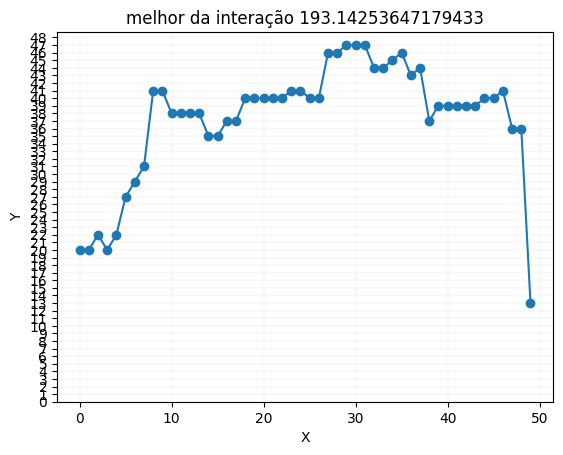

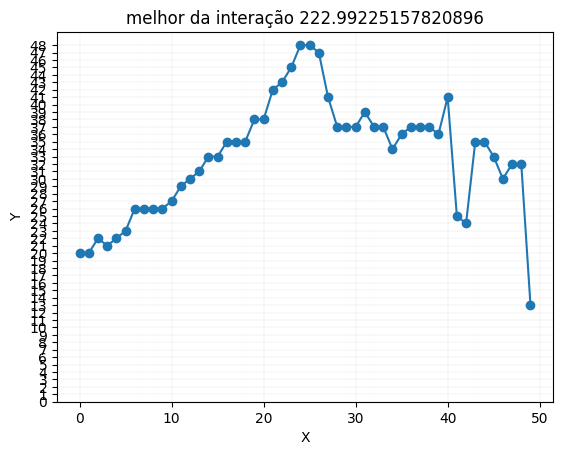

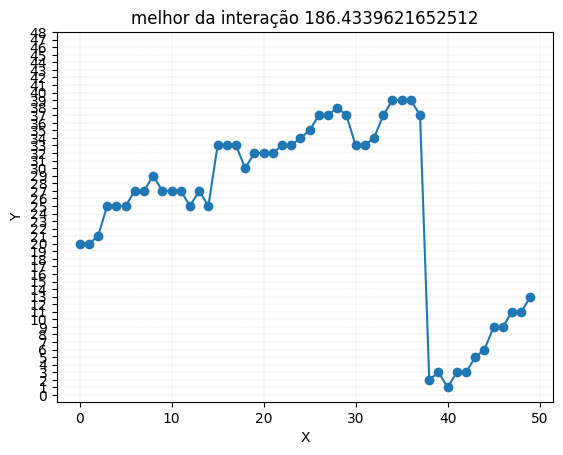

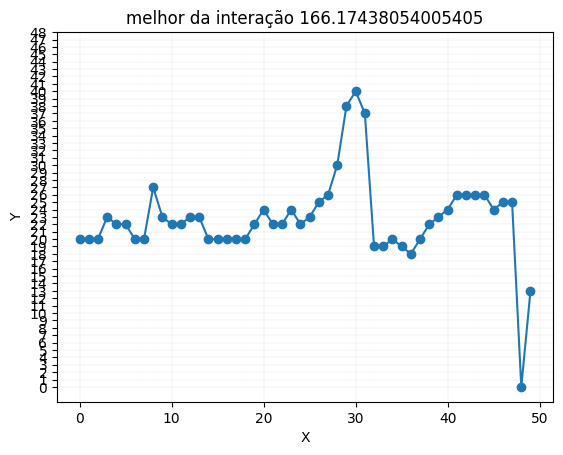

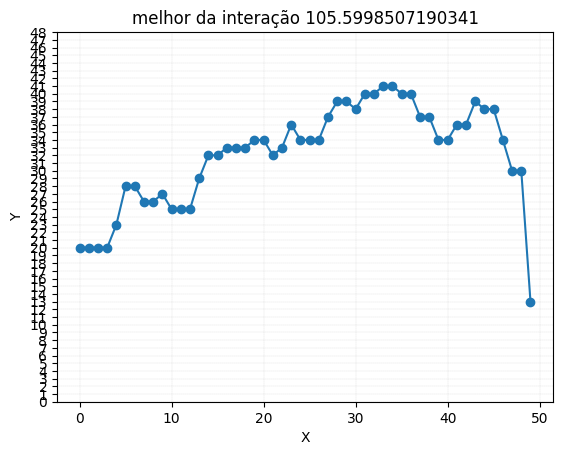

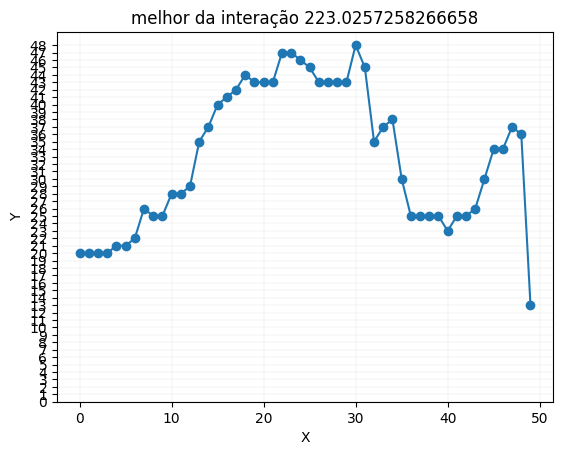

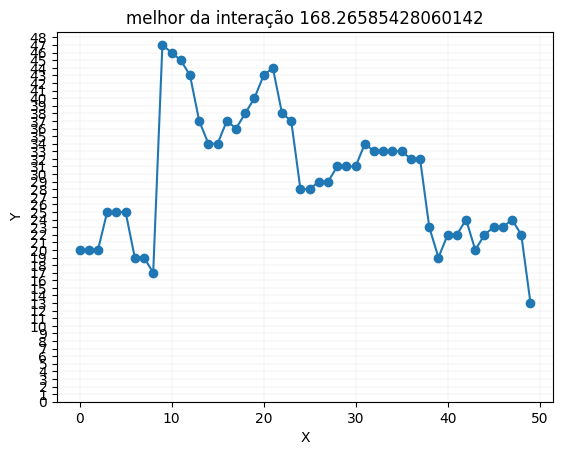

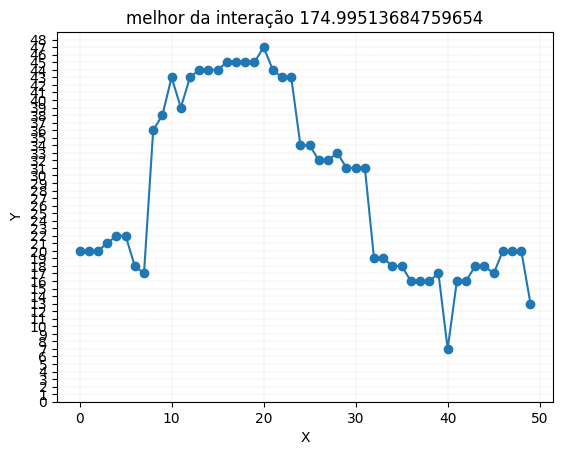

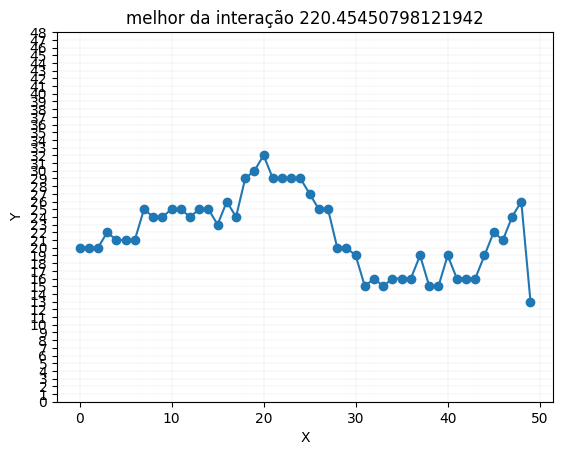

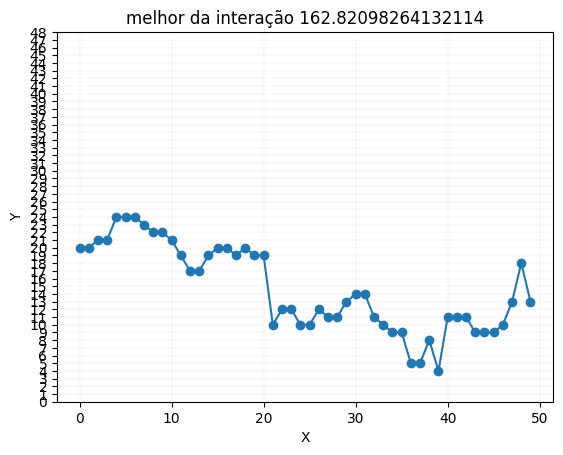

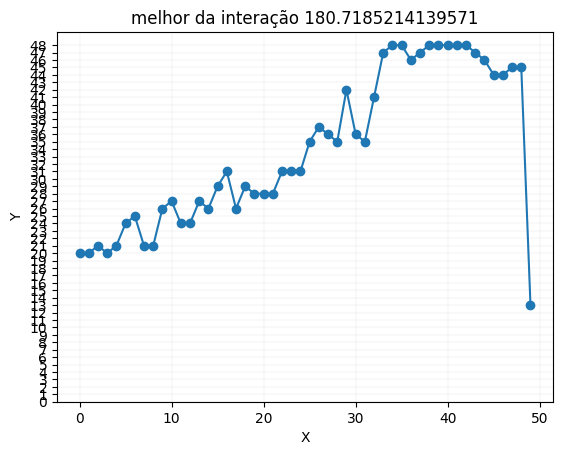

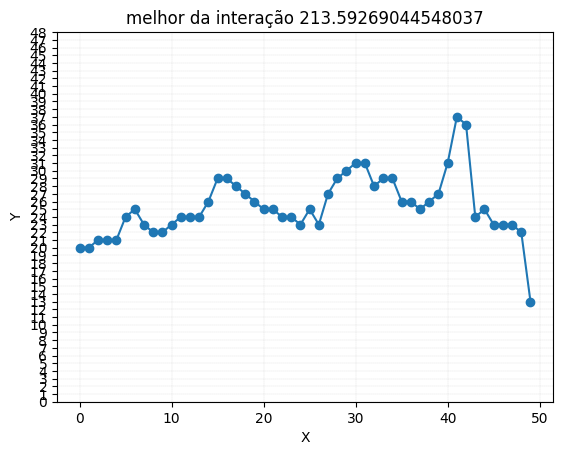

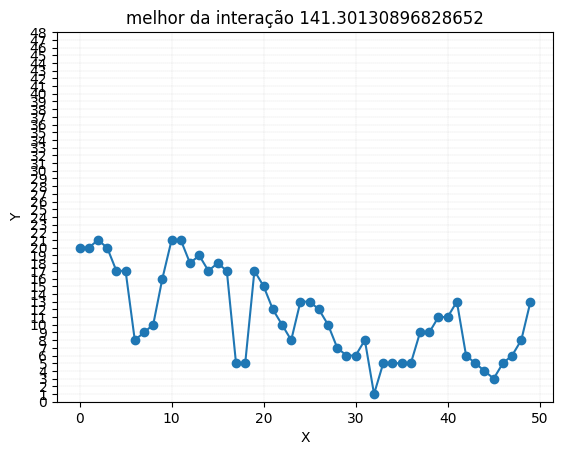

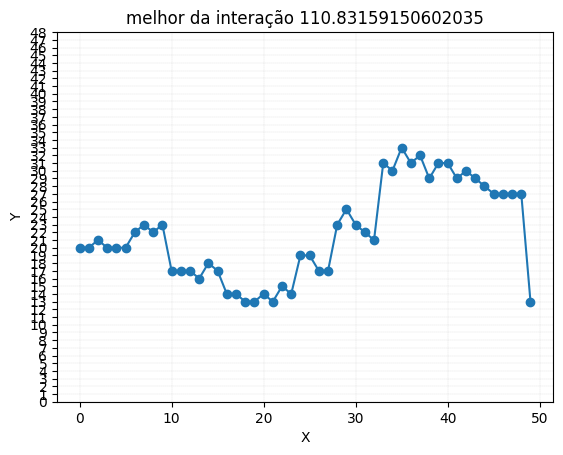

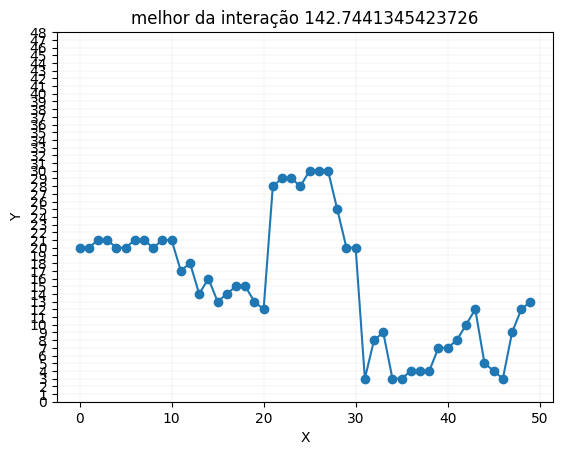

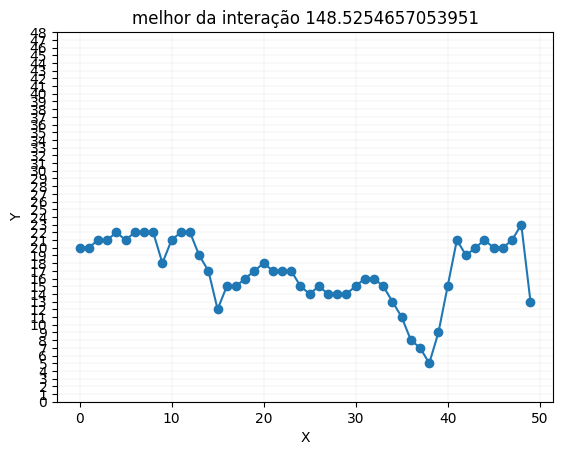

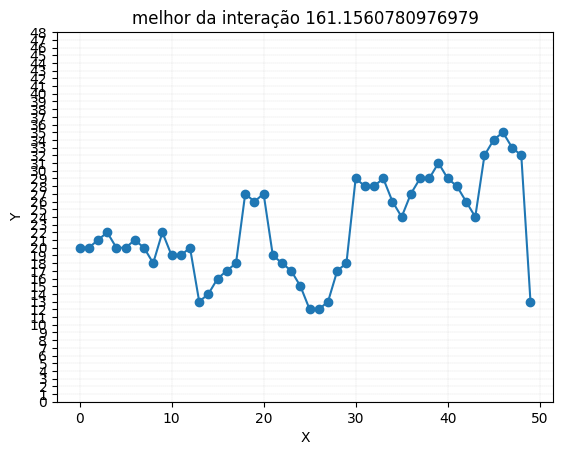

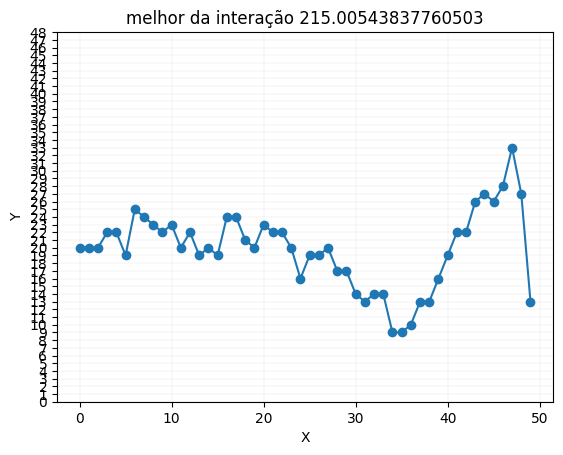

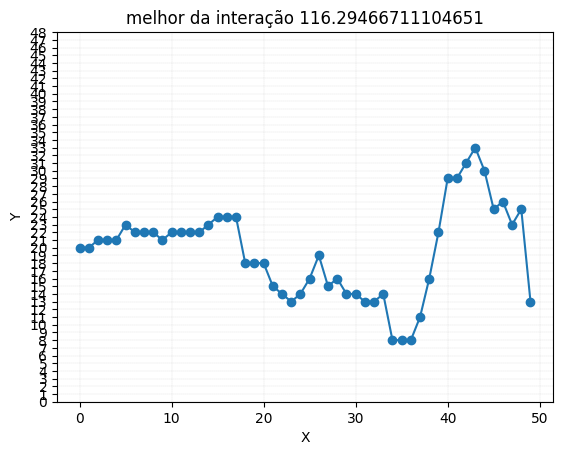

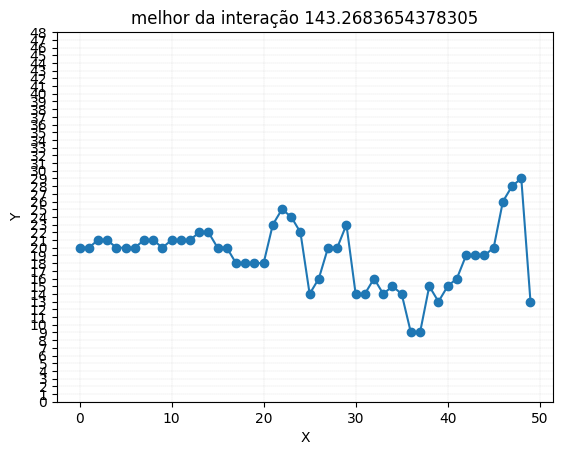

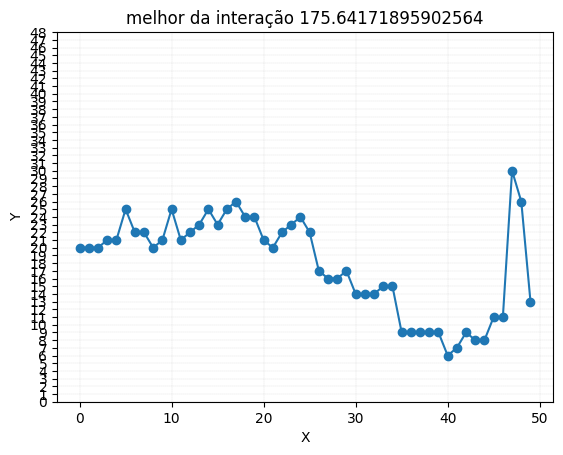

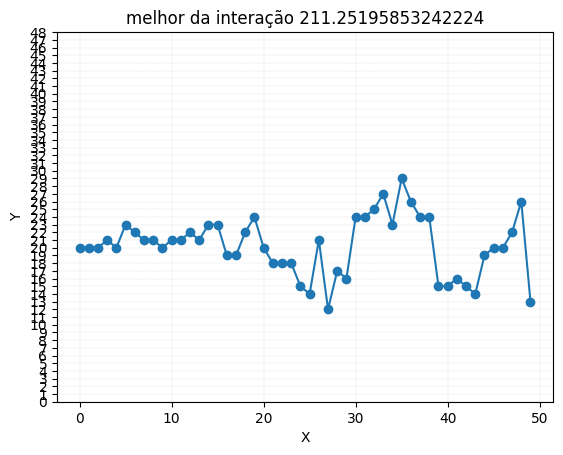

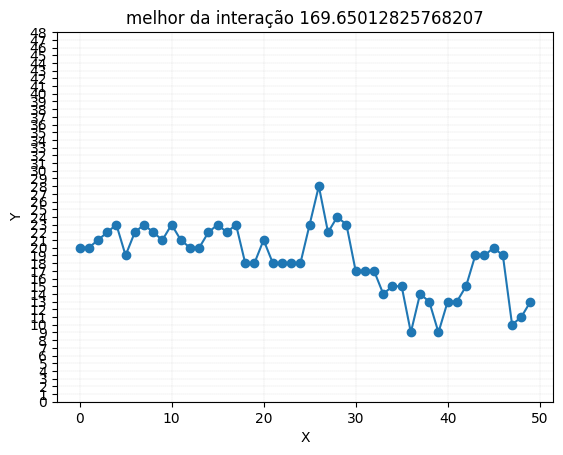

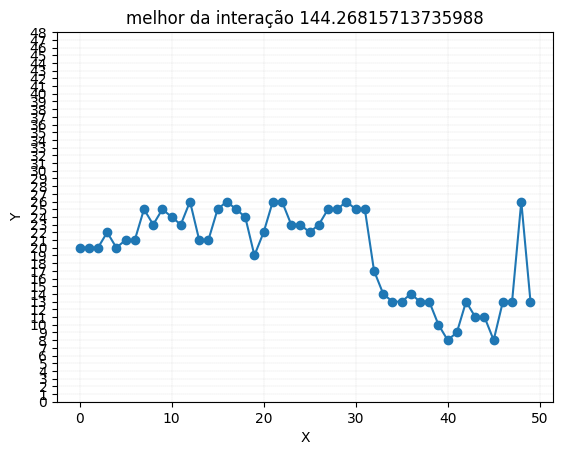

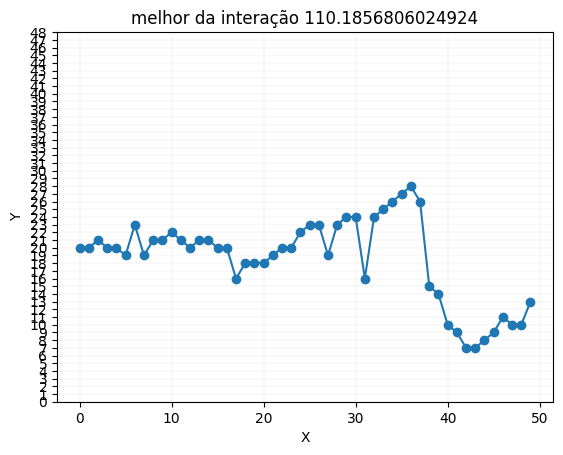

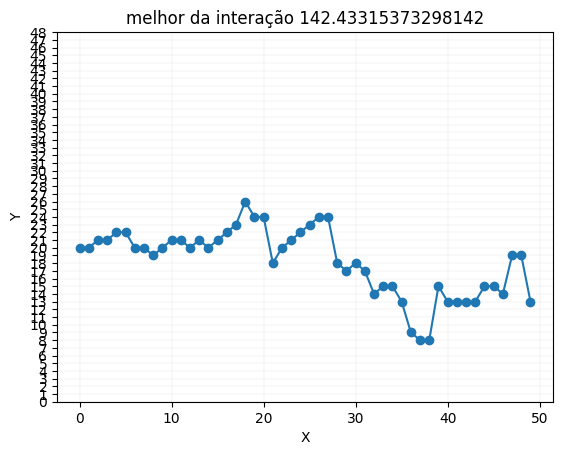

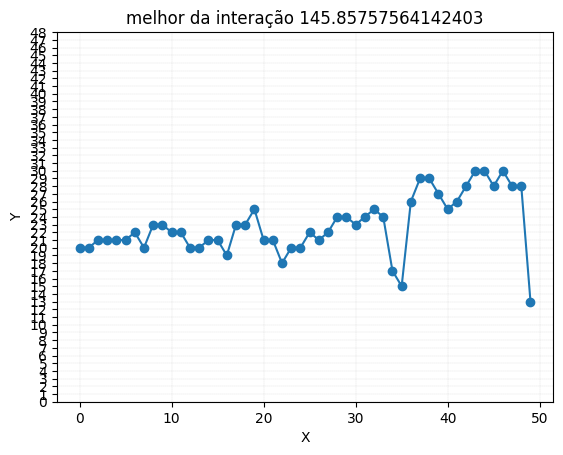

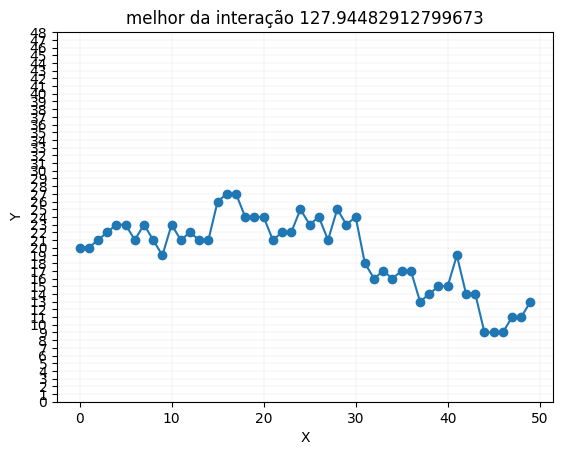

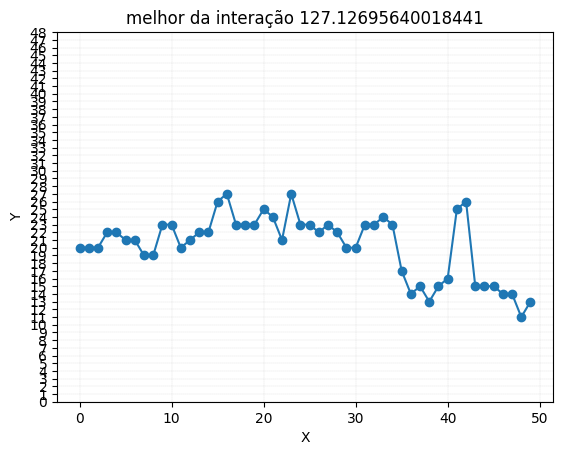

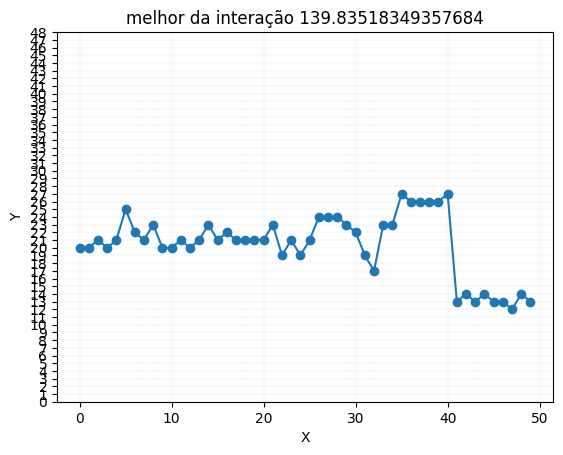

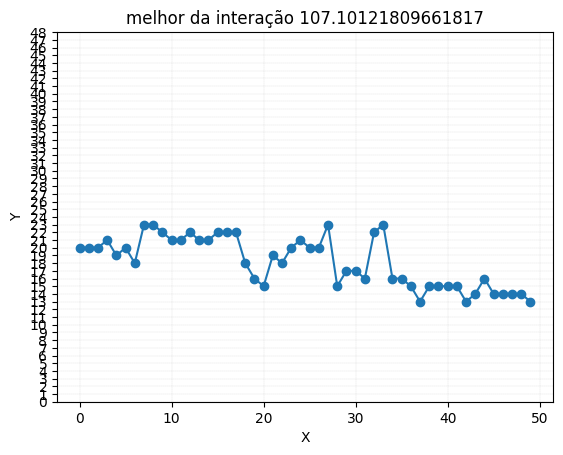

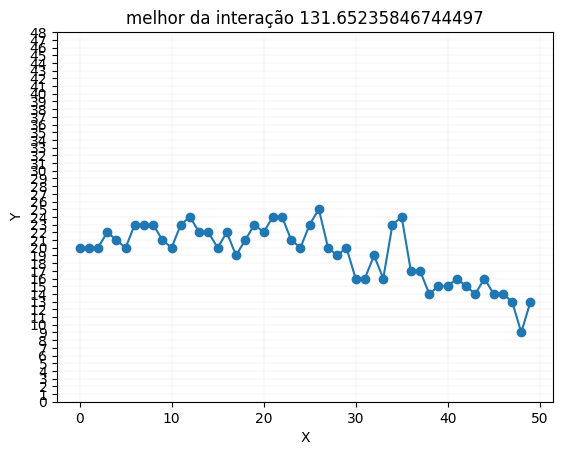

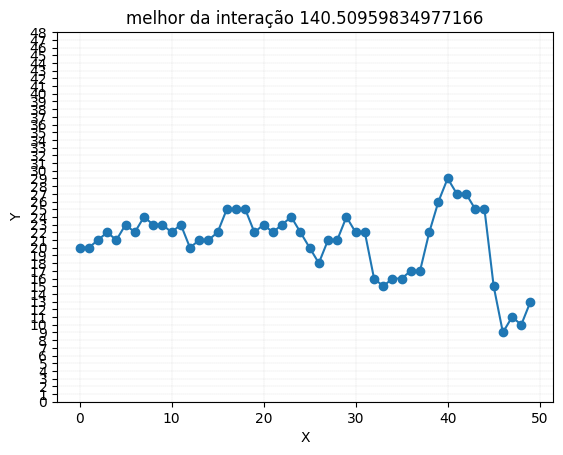

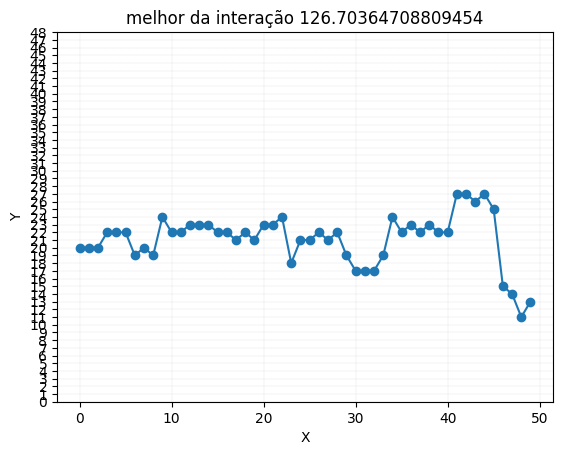

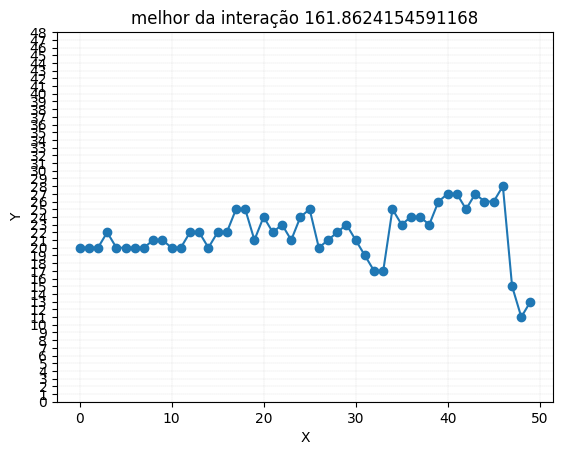

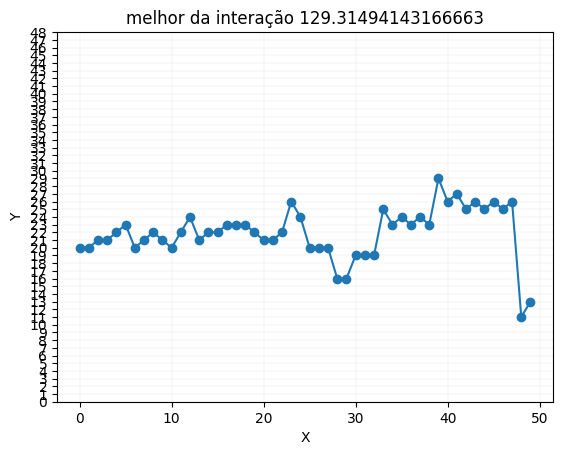

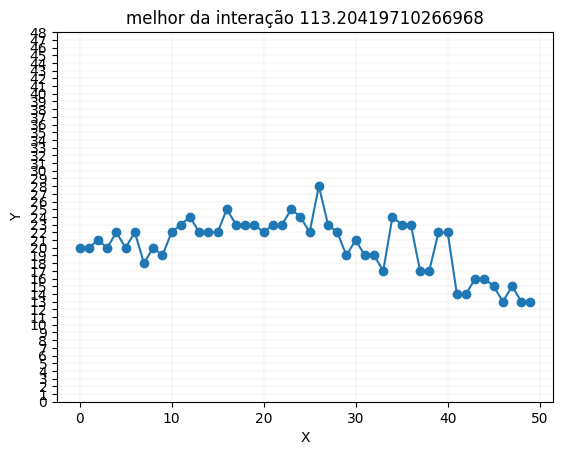

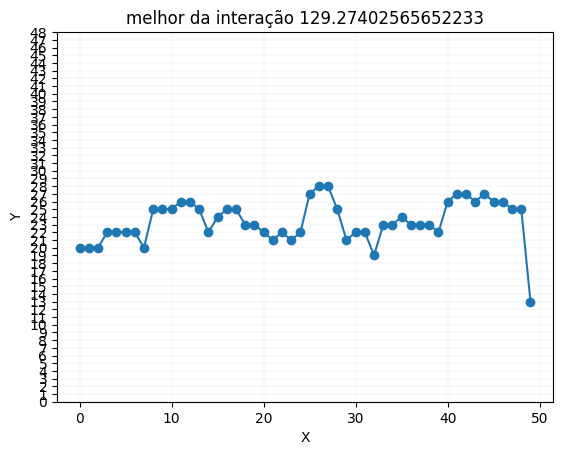

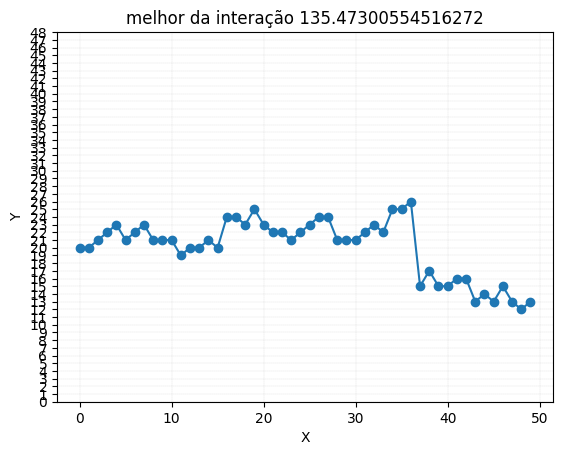

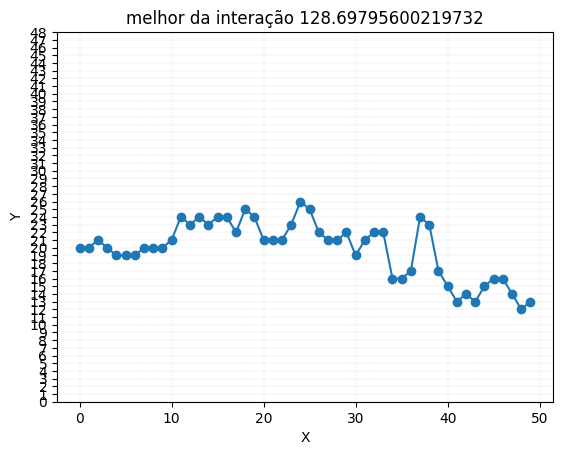

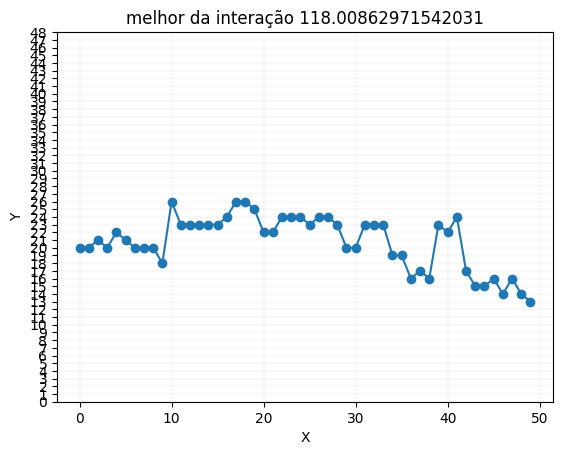

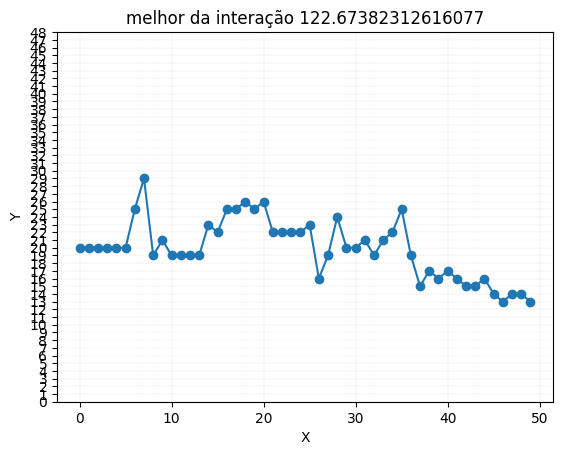

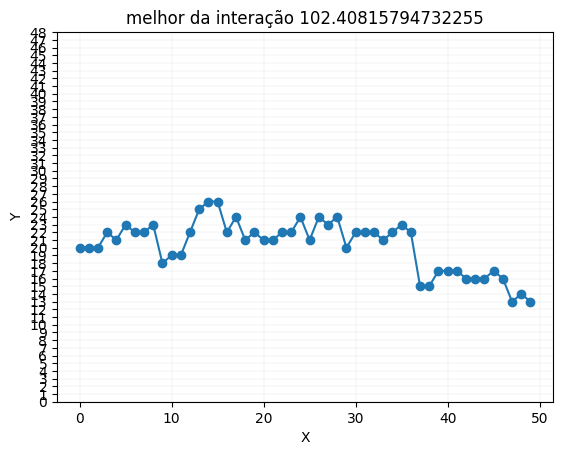

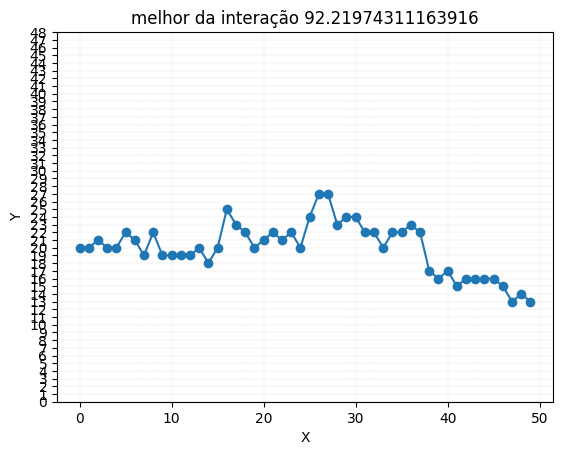

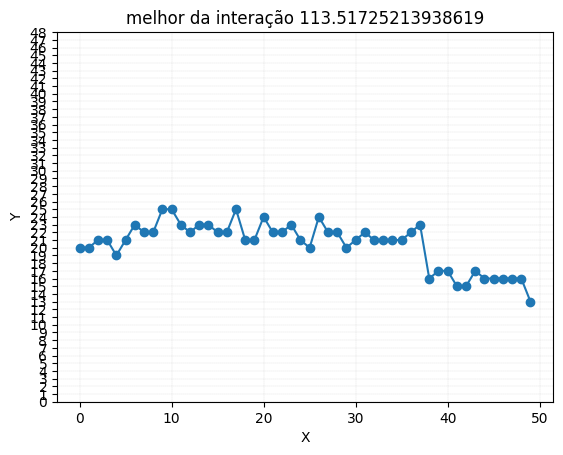

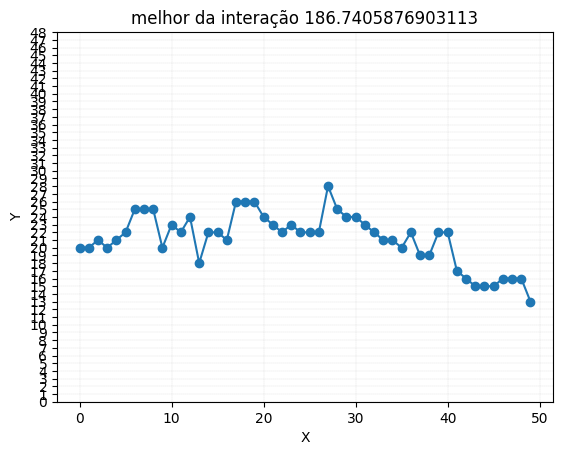

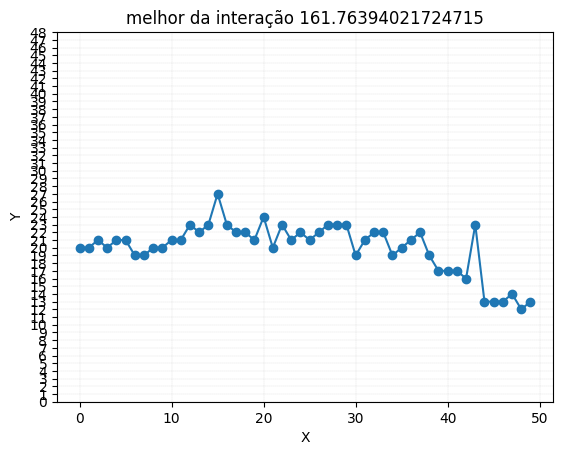

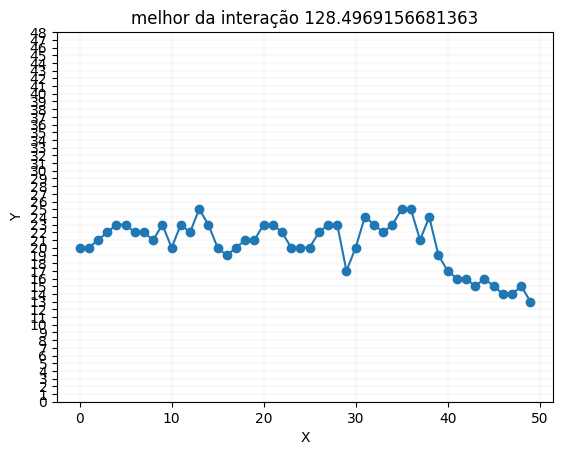

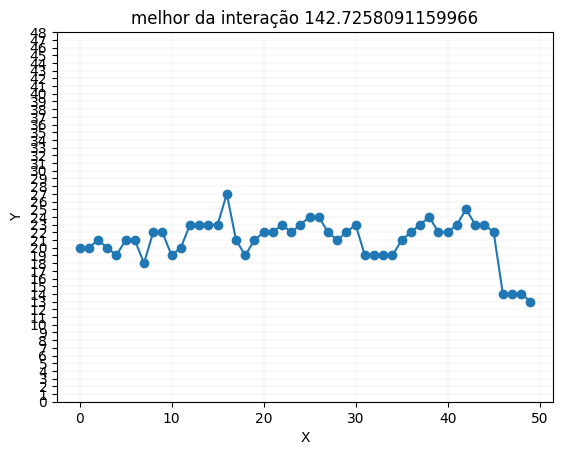

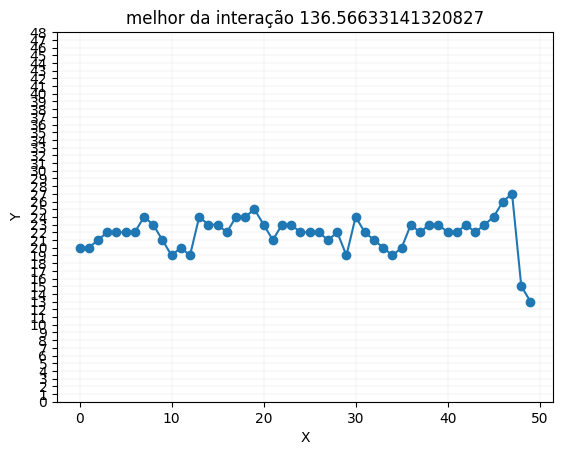

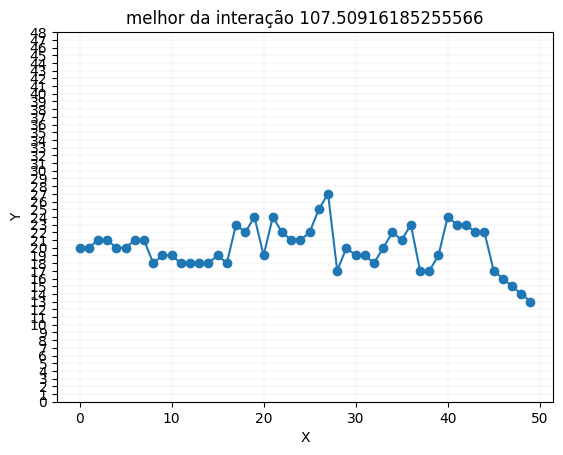

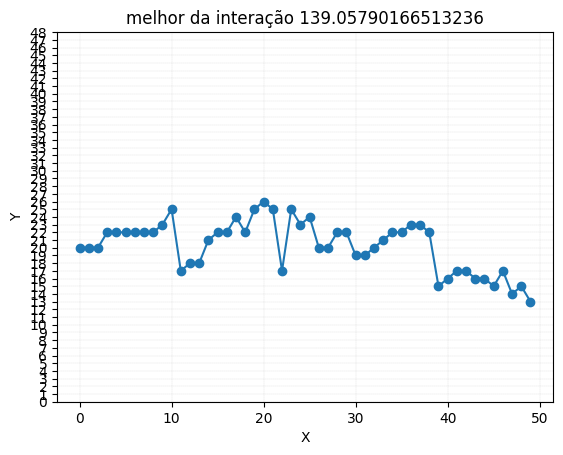

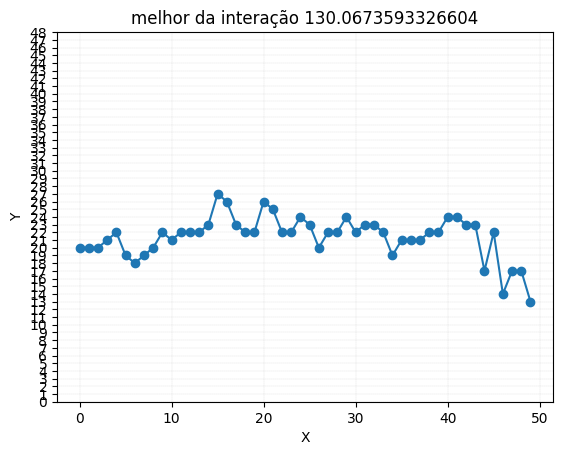

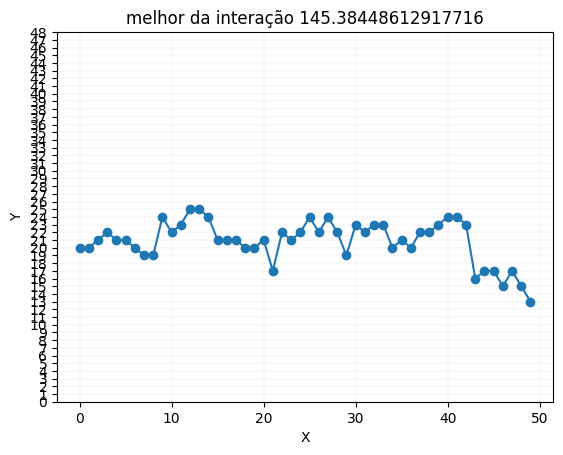

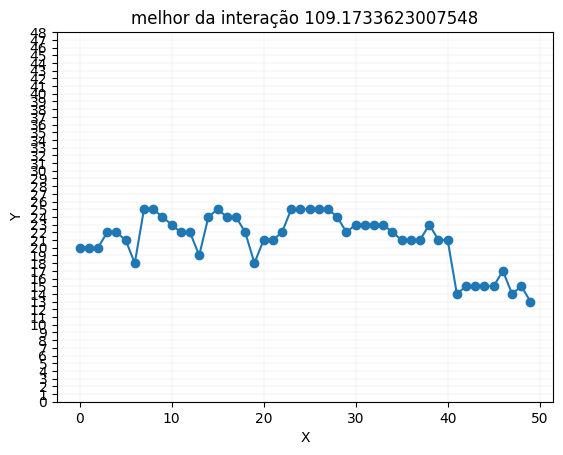

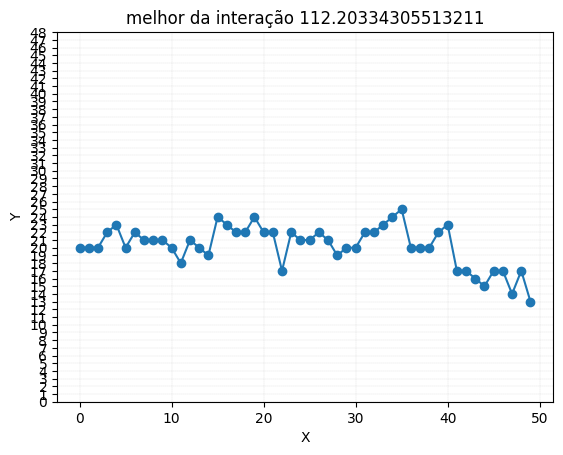

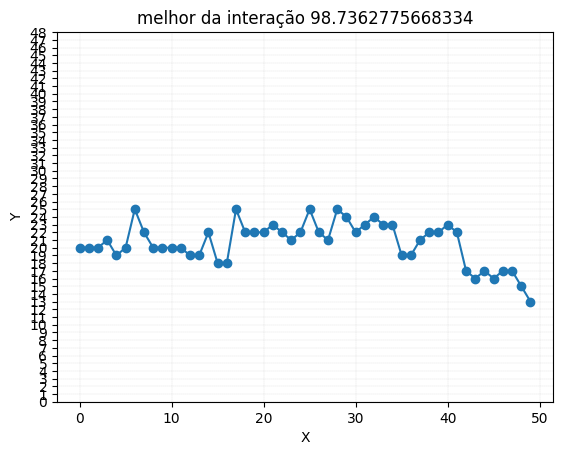

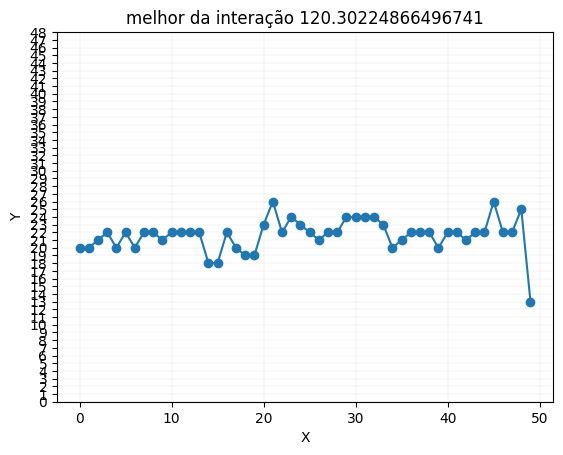

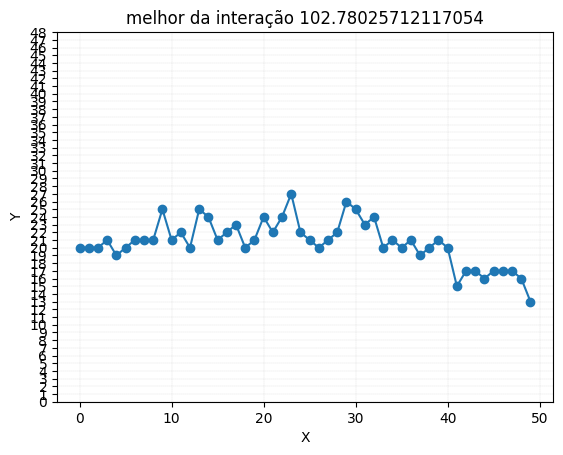

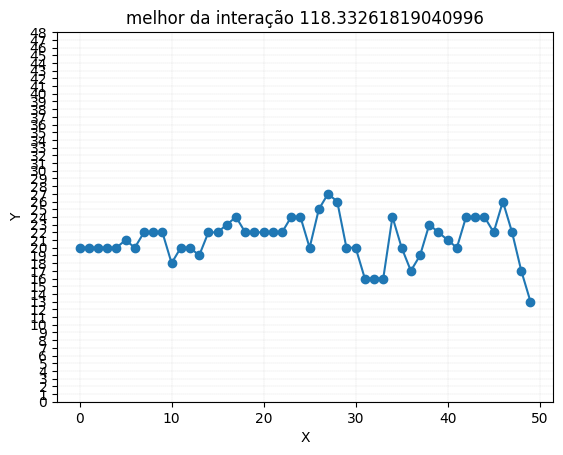

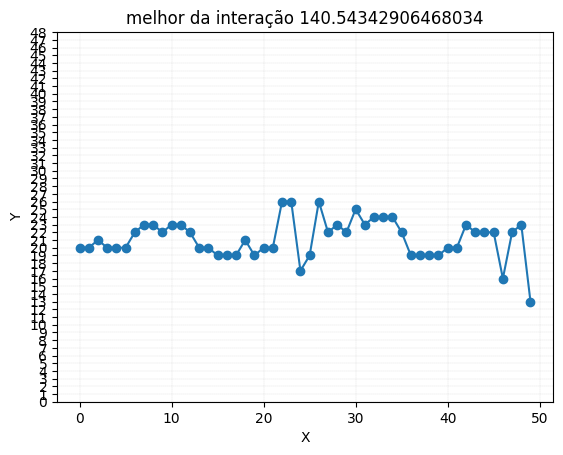

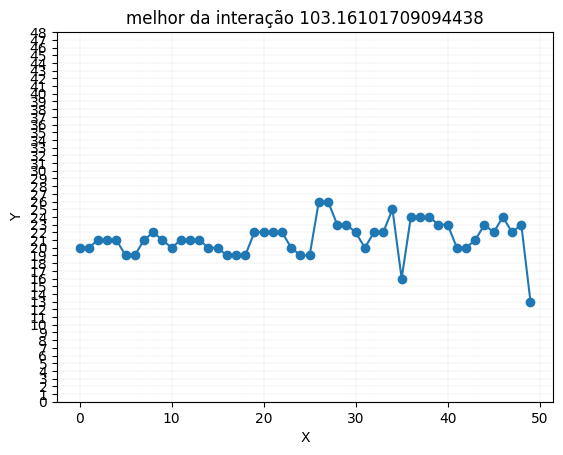

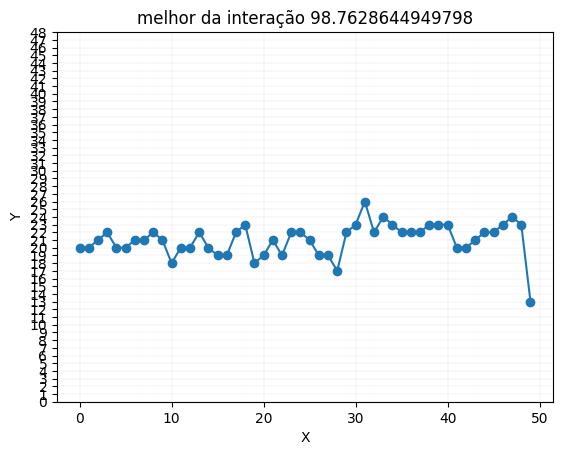

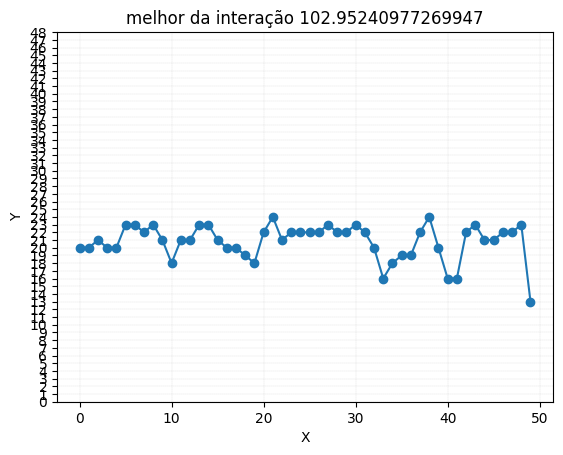

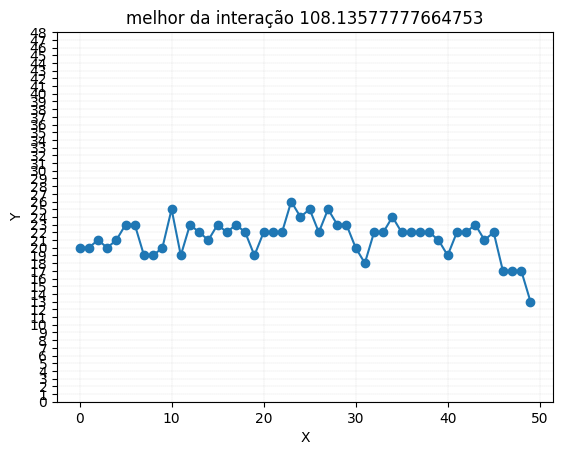

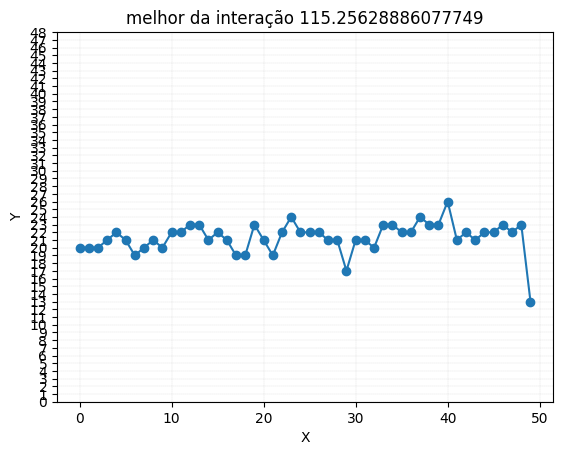

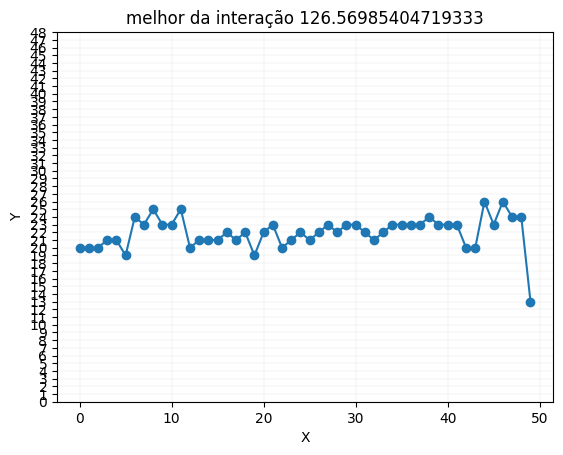

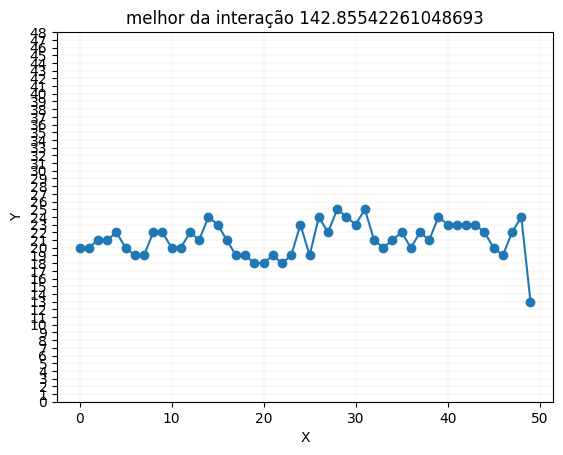

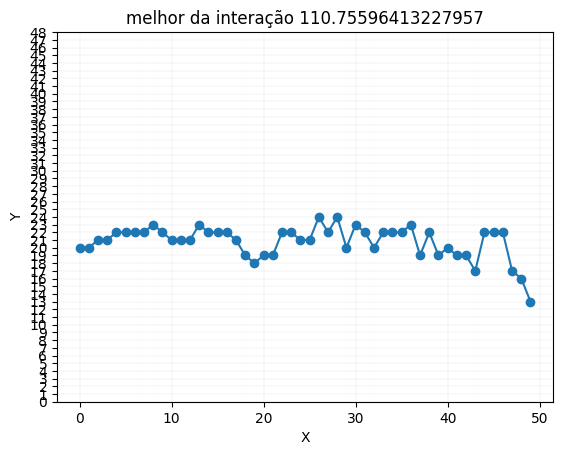

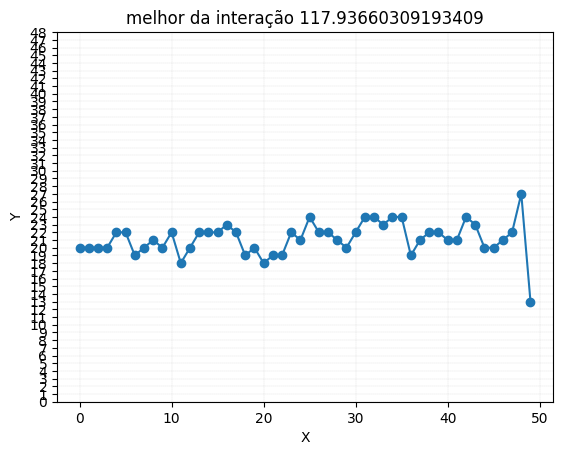

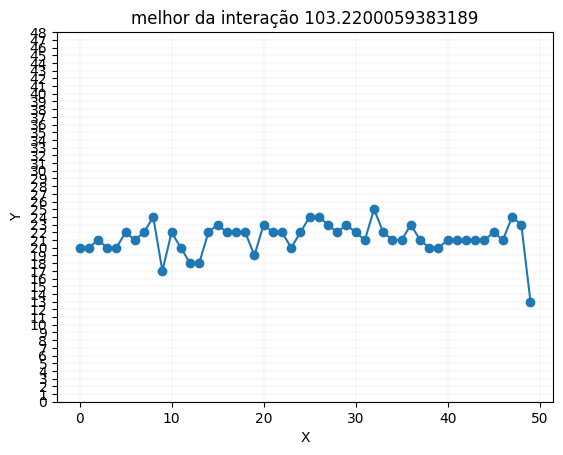

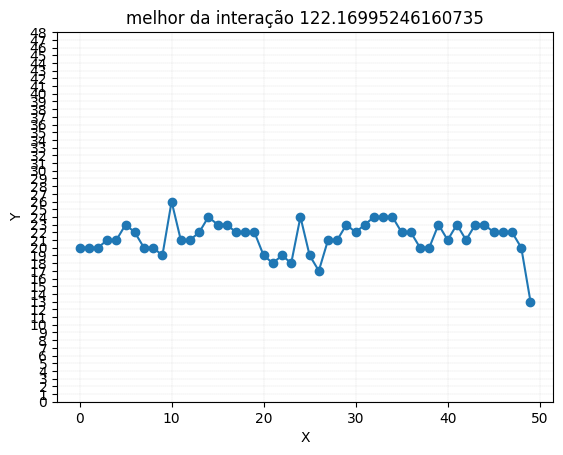

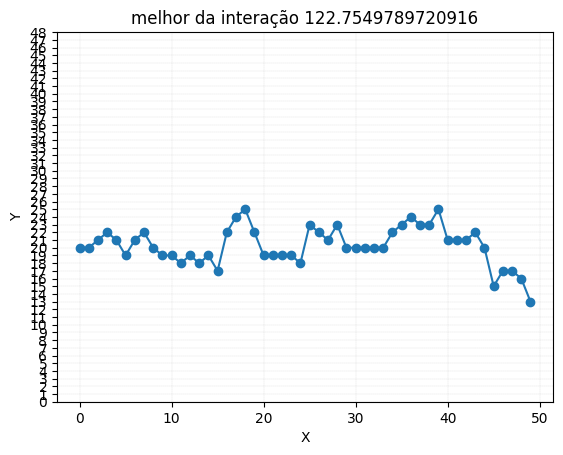

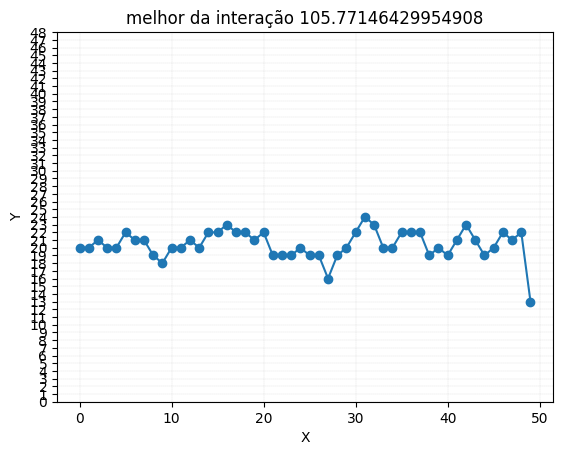

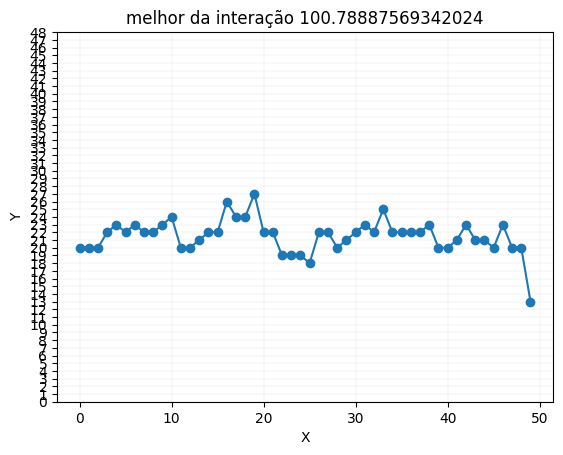

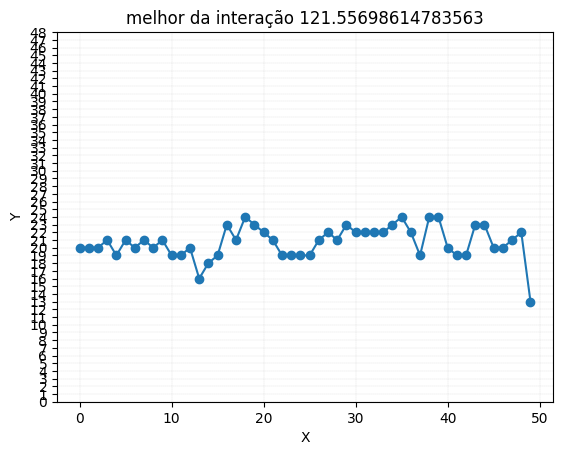

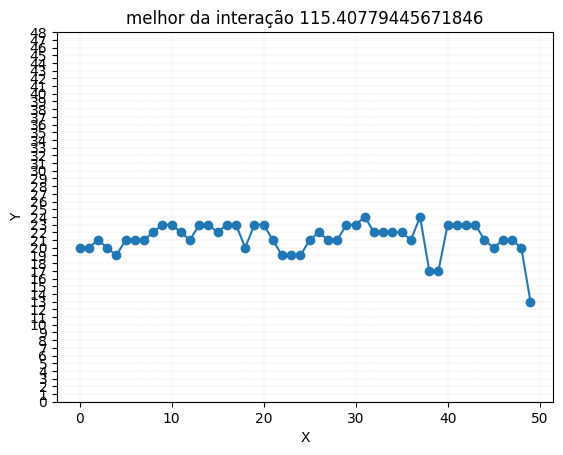

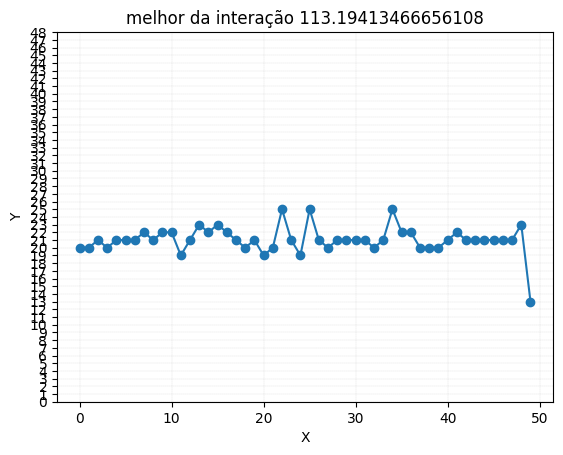

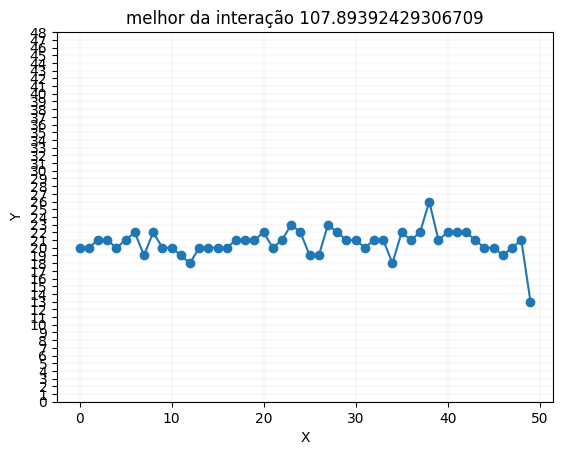

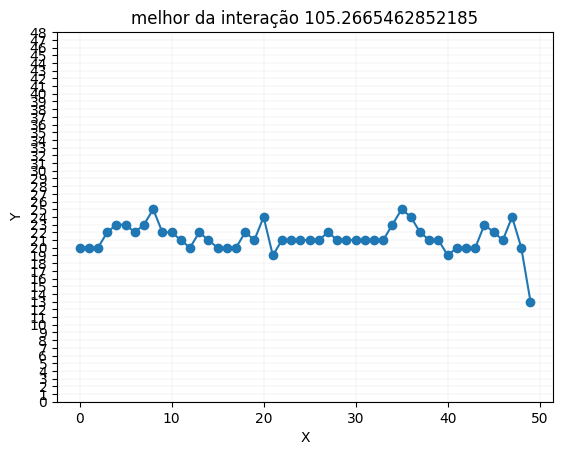

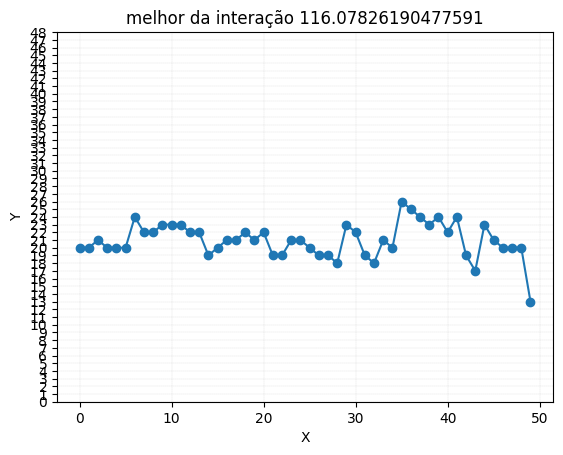

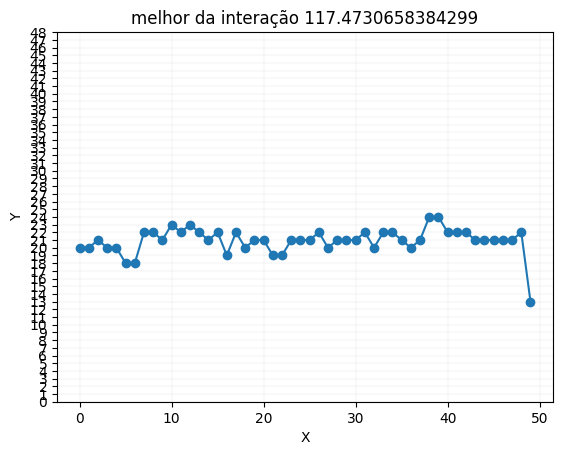

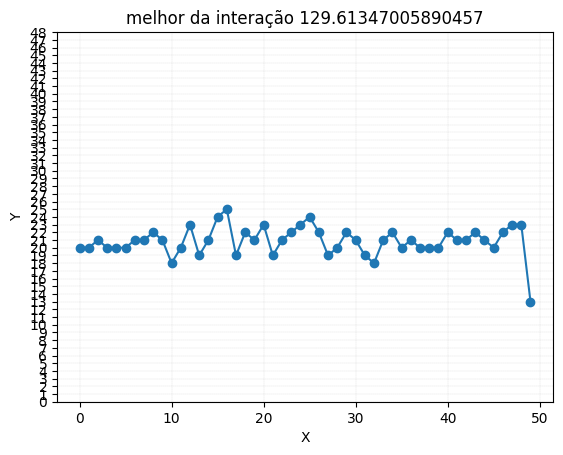

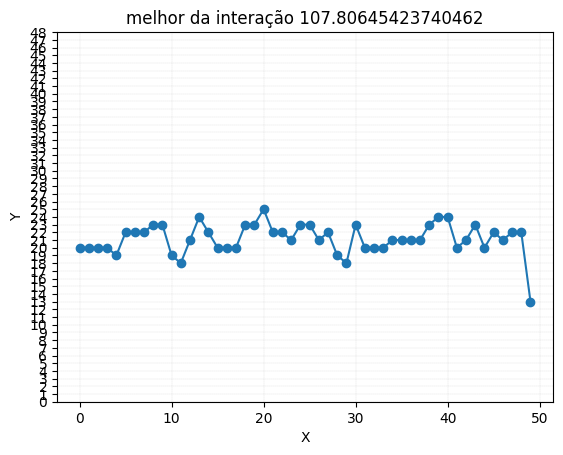

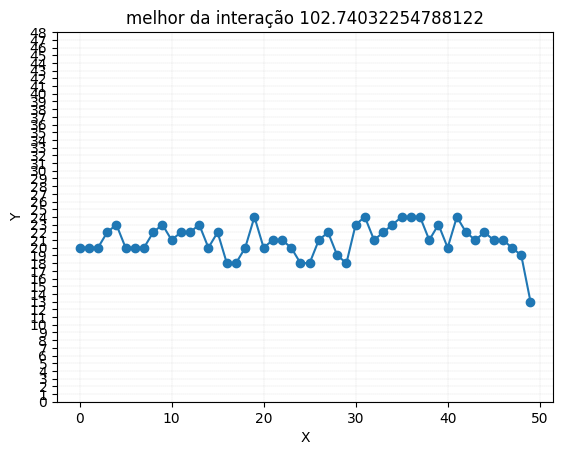

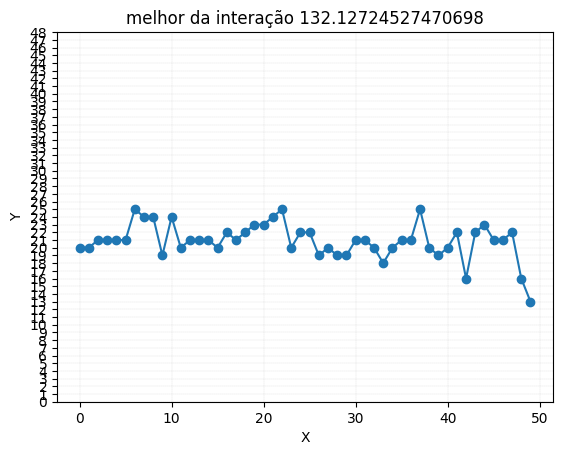

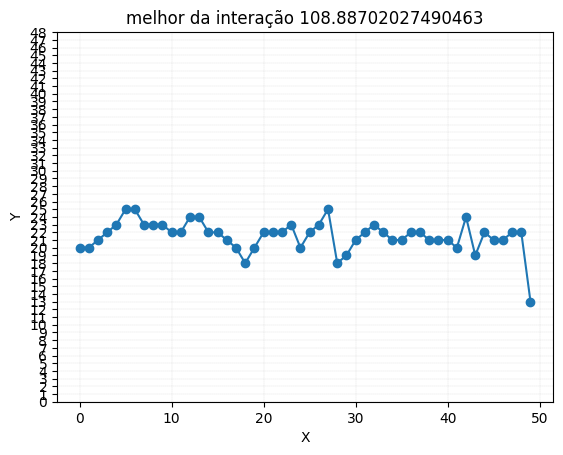

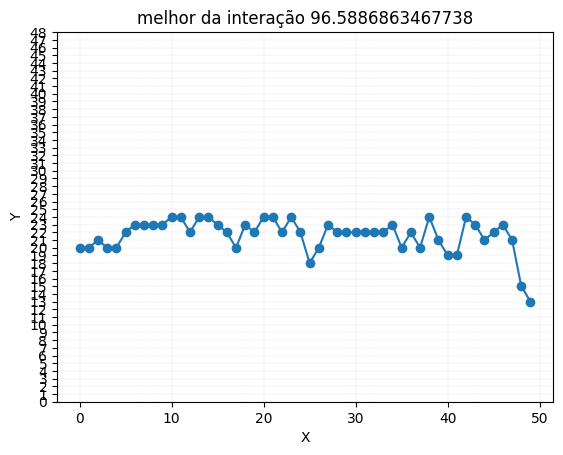

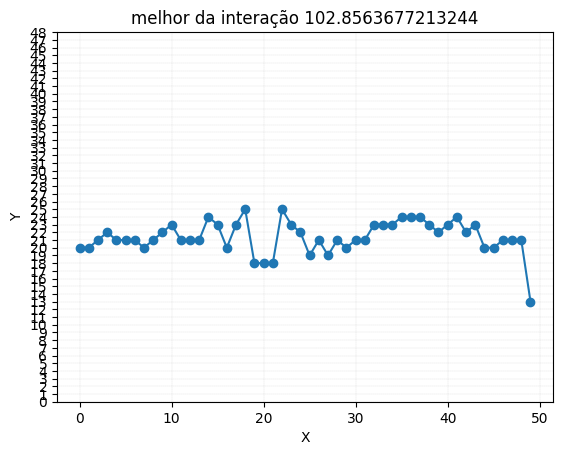

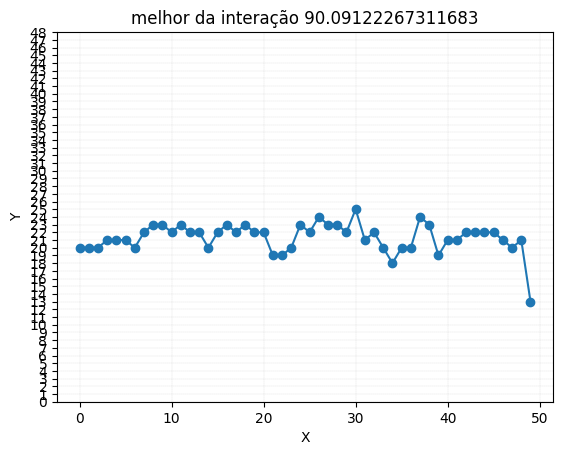

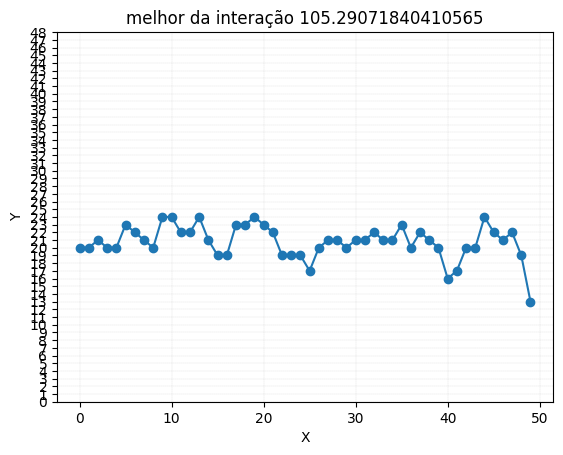

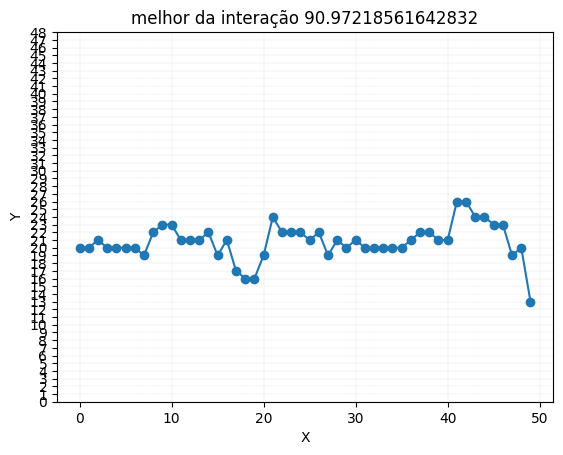

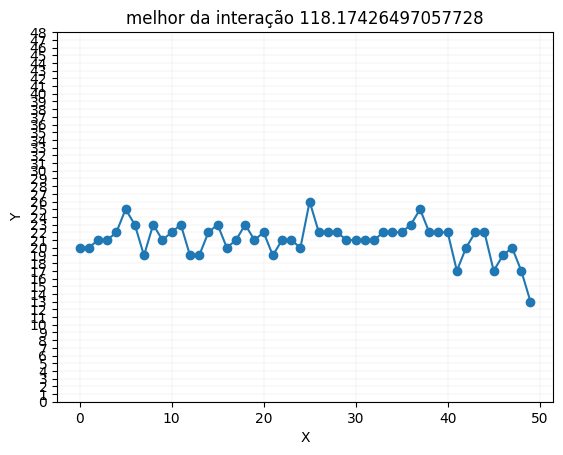

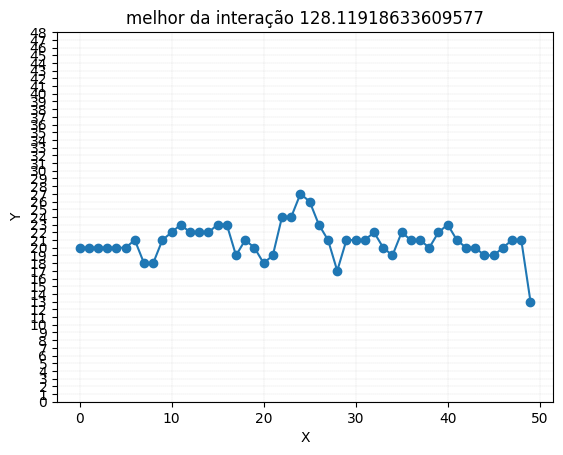

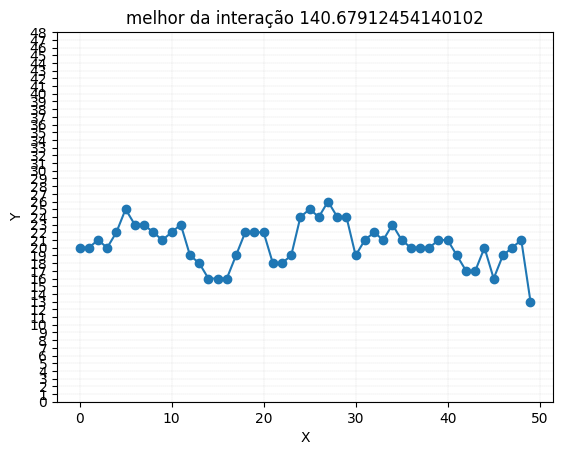

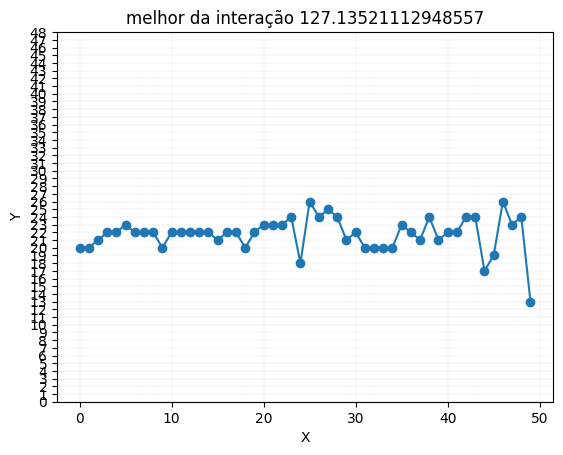

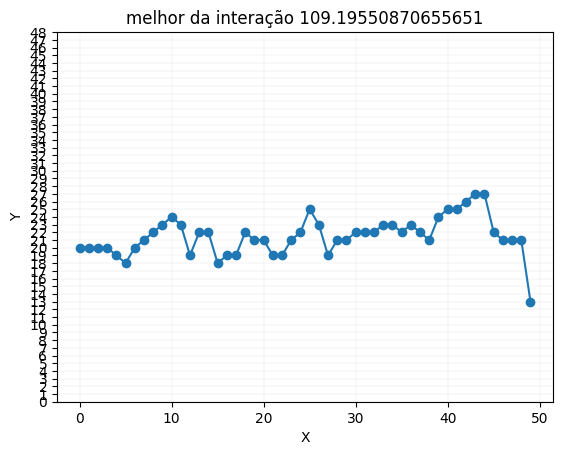

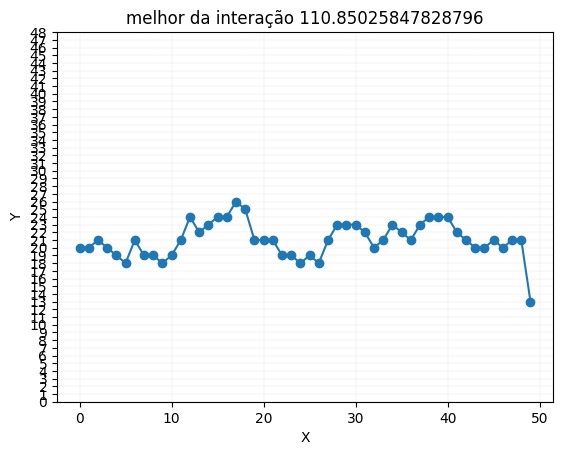

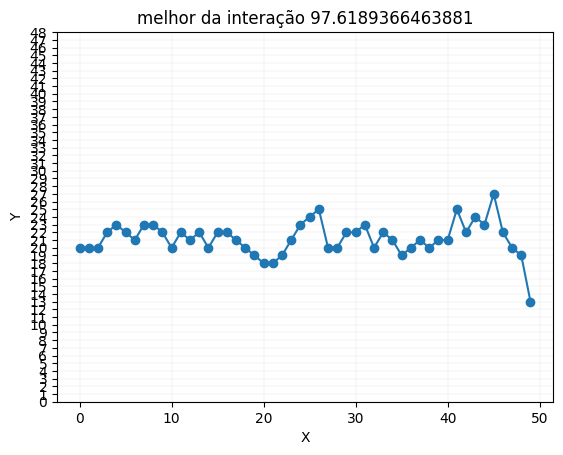

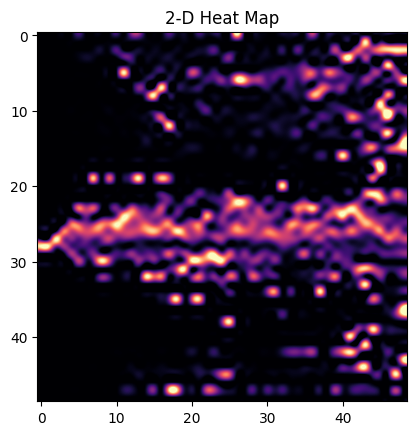

In [49]:
algoritmo_genetico = AlgoritmoGenetico(quantidade_de_formigas = 10, quantidade_de_ciclos = 100)

<bound method AlgoritmoGenetico.executar of <__main__.AlgoritmoGenetico object at 0x7beb2d4822f0>>